In [1]:
# !pip install chains

In [2]:
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List, Sequence

In [3]:
load_dotenv()
# os.environ['OPENAI_API_KEY']

True

# implementing the following chain
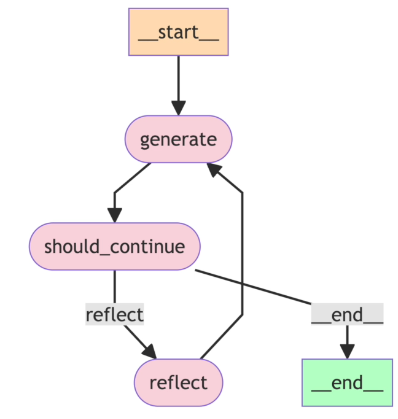

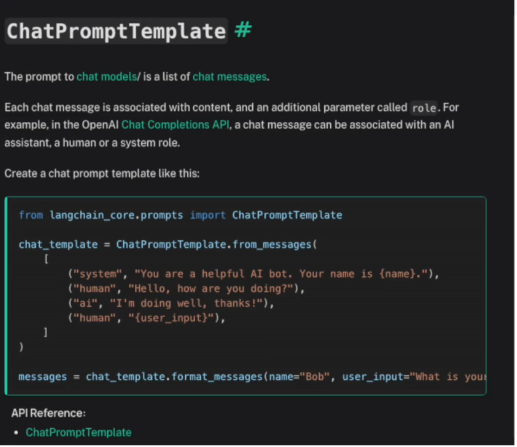
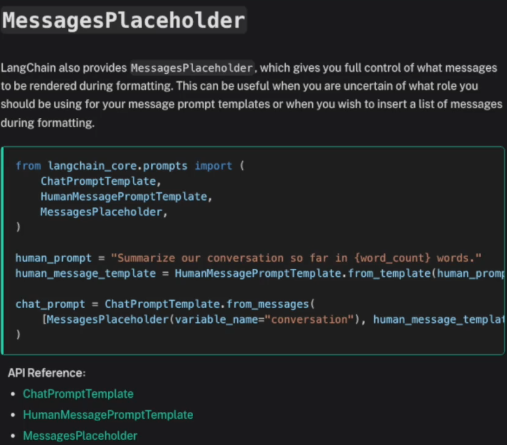

In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

# Writing the prompt and chains
1- writing the reflection prompt. It's supposed to act as our predict. It's going to review a twitter post and criticize it. It says how it can be better to improve it.
  1-A- Using a placeholder for other messages (history messeages) and that adds the history messages. Agent will invoke and criticize to give recommendation over and over. 
2- generation prompt: this generates the tweets that will be revised over and over again after getting a feedback from the reflection prompt
  2-A- A placeholder for all reflections and revisions that we'have had so far.
3- Creating a 

In [5]:
reflection_prompt = ChatPromptTemplate.from_messages([
    (# writing the reflection prompt. It's supposed to act as our predict. It's going to review a twitter post and criticize it. It says how it can be better to improve it.
    "system",
    "Your are a viral twitter influncer grading  a tweet. Generate critique and recommendations for the user's tweet."
    "Always provide detailed recommendations, including requests for length, virality, style, etc."
    ),
    MessagesPlaceholder(variable_name="messages"), #Using a placeholder for other messages (history messeages) and that adds the history messages. Agent will invoke and criticize to give recommendation over and over. 
]) # When we initialize the reflection point, we're going plug in to this prompt. 

generation_prompt = ChatPromptTemplate.from_messages([#generation prompt: this generates the tweets that will be revised over and over again after getting a feedback from the reflection prompt
    (
    "system",
    "You are a twitter techie influncer assistant, tasked with writing excellent twitter posts."
    "Generate the best twitter post possible for the user's request."
    "If the user privides critique, respond with a revised version of your previous attempts.",
    ),
    MessagesPlaceholder(variable_name="messages"), # A placeholder for all reflections and revisions that we'have had so far.
])


In [6]:
# Create the chain
llm=ChatOpenAI() # initializing LLM (gpt 3.5 turbo)
# creating two simple chains. For this purpose, we use langchain expression for it
generate_chain = generation_prompt | llm
reflect_chain = reflection_prompt | llm

# Defining our LangGraph Graph

In [7]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph
# END is a constant that shows the langGraph ending node. When we reach this node, the compiler stops the langGraph's execution

# we need to import messageGraph. It's a graph that its state is sequence of messages.

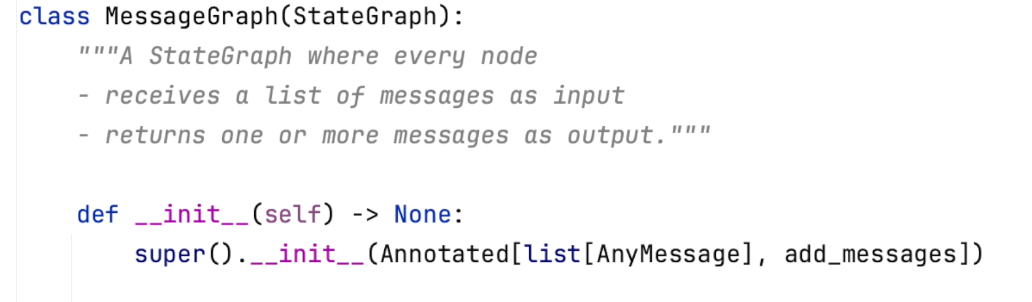

## It takes the input and simply add it to messages list, then it is a new state

In [8]:
#Constant that show the nodes generate and reflect
REFLECT = 'reflect'
GENERATE = 'generate'

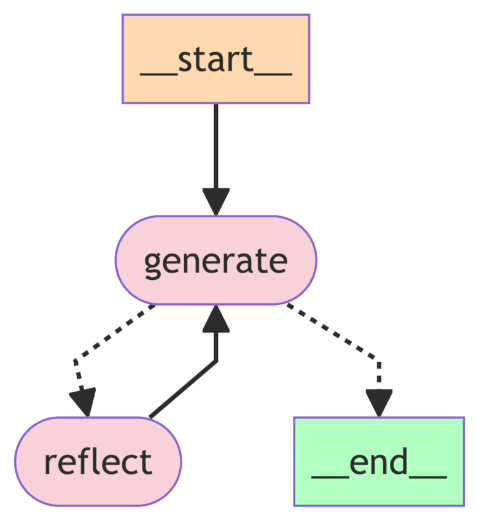

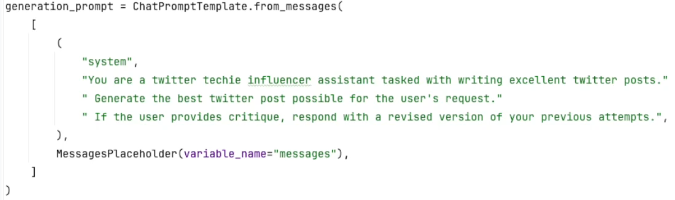

In [9]:
def generation_node(state: Sequence[BaseMessage]):
    return generate_chain.invoke({"messages":state}) # it uses the prompt that is shown in the screenshot in the previous cell

#LangGraph when gets the response from the LLM, it will take the return value. Then, the return value will be appended to the state (the list of messages). It's what happens under the hood

In [10]:
def reflection_node(messages: Sequence[BaseMessage]):
    res = reflect_chain.invoke({"messages":messages})
    return [HumanMessage(content=res.content)]
#this function gets the sequence of messages, then it invokes the message from reflection node. The returned response from LLM is changed to HumanMessage and it is returned (output of function).
# Why we do that? ANS: because we trick the LLM to think that it is user/human message. Here Human is the critic to make LLM improves it response.

## Initilize our graph

In [11]:
builder = MessageGraph()
builder.add_node(GENERATE, generation_node)
builder.add_node(REFLECT, reflection_node)

# Telling the LangGraph that starting node is the generate node
builder.set_entry_point(GENERATE)

In [12]:
# Now we need to implement the logic that say the tweet is fine and we can finish our graph execution, or we need our reflection step. For this purpose, 
# We need to write a function called should_continue. It receives a state (all message), then it decides which node should be moved (end or reflect)
# Can we use LLM to decide (do reasoning) to end or going to which node. It's mind blowing

def should_continue(state: List[BaseMessage]): # It's very simple reasoning
    if len(state)>6:
        return END
    return REFLECT

# Now we want to tell LangGraph when we execute the generate node, then add edge to say which node to go (END or Reflect nodes)
builder.add_conditional_edges(GENERATE, should_continue)
# After getting the feedback, we want to revise the tweet. So, we add a node between node and generate nodes
builder.add_edge(REFLECT, GENERATE)
    

# Now, we build all the nodes and edges. We can compile the code

In [13]:
graph = builder.compile()

In [14]:
# After writeing the graph, we can visualize it
print(graph.get_graph().draw_mermaid())
graph.get_graph().print_ascii()

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	generate(generate)
	reflect(reflect)
	__end__([<p>__end__</p>]):::last
	__start__ --> generate;
	reflect --> generate;
	generate -.-> reflect;
	generate -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

          +-----------+            
          | __start__ |            
          +-----------+            
                *                  
                *                  
                *                  
          +----------+             
          | generate |             
          +----------+             
          ***        ...           
         *              .          
       **                ..        
+---------+           +---------+  
| reflect |           | __end__ |  
+---------+           +---------+  


### When you copy the output of the previous cell, you need to go to mermaid.live and past the output under code tab. It shows this:
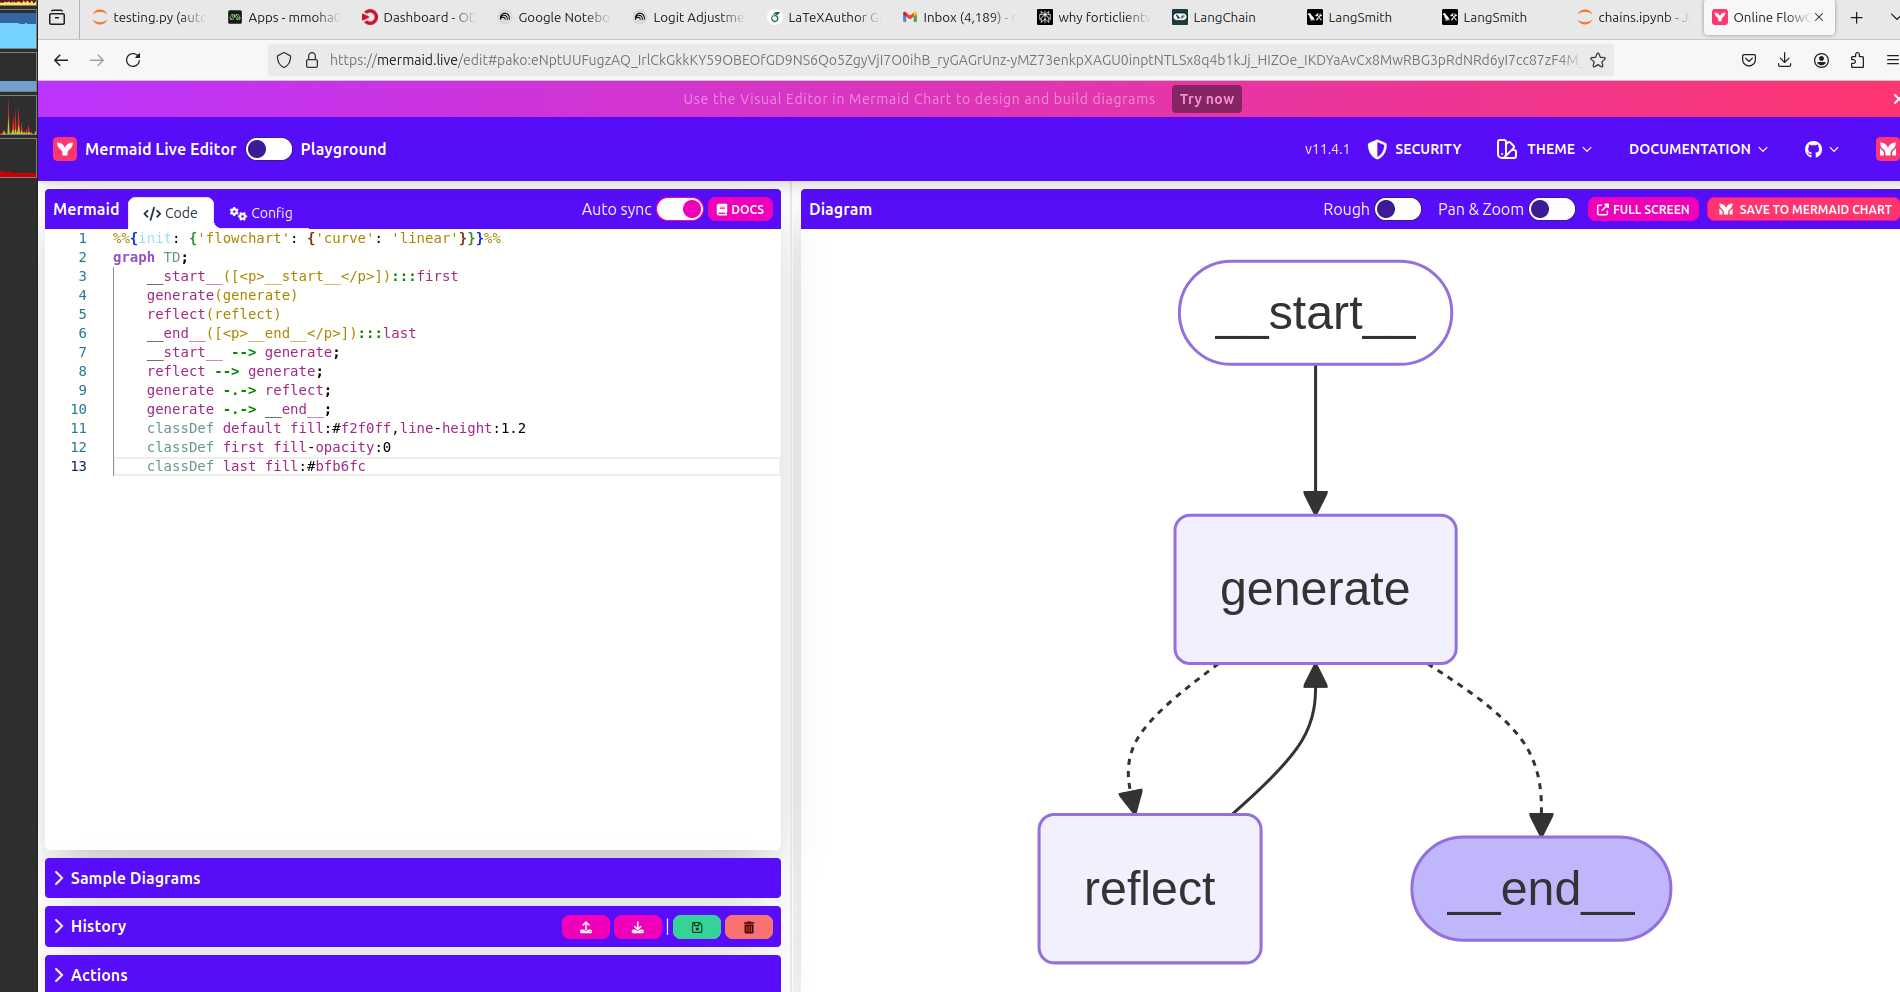

In [15]:
inputs = HumanMessage(content="""Make this tweet better:"
                                    @LangChainAI
            — newly Tool Calling feature is seriously underrated.

            After a long wait, it's  here- making the implementation of agents across different models with function calling - super easy.

            Made a video covering their newest blog post

                                  """)
response = graph.invoke(inputs)